## Process image
Input: image folder collected by Xiaohu.
Output: image numpy arrays and an index dictionary.

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import cv2
from collections import defaultdict
import matplotlib.pyplot as plt
import sys
import psutil

In [2]:
with open('../statesToData.pickle', 'rb') as handle:
    statesToData = pickle.load(handle)

In [3]:
print(statesToData["CA"].CENSUS_ID) # 11 digits.
print(statesToData.keys())

40        06111000902
41        06111000902
42        06111000902
43        06111000902
44        06111000902
             ...     
781780    06057000701
781781    06057000701
781782    06057000701
781811    06053011900
781812    06053011900
Name: CENSUS_ID, Length: 155989, dtype: object
dict_keys(['NC', 'WI', 'NY', 'MD', 'PA', 'CA', 'TX', 'AZ', 'WA', 'IL', 'KY', 'MT', 'IA', 'GA', 'ME', 'VA', 'SC', 'WV', 'FL', 'NH', 'MN', 'NE', 'AR', 'NJ', 'SD', 'NM', 'OK', 'MI', 'VT', 'ID', 'DE', 'MA', 'WY', 'CO', 'IN', 'AL', 'TN', 'HI', 'AK', 'OH', 'RI', 'LA', 'OR', 'KS', 'UT', 'MO', 'DC', 'NV', 'ND', 'MS', 'CT'])


In [4]:
# file names in the folder
standard_file_name_list = ['road_0.tif', 'road_1.tif', 'building_0.tif', 'building_1.tif']
num_channels = len(standard_file_name_list)

In [5]:
# check directory names from Xiaohu's collection
def digit_counts(list_, SAT = False):
    # output the number of items with 10 and 11 digits. 
    # give warning if the items have number of digits different from 10 and 11.
    d_10 = 0
    d_11 = 0

    if SAT:
        for idx in np.arange(len(list_)):
            if len(list_[idx]) == 17: # 10+3+4 because 3 represents "wms" and 4 represents ".jpg" ...
                d_10 += 1
            elif len(list_[idx]) == 18: # 11+3+4 because 3 represents "wms" and 4 represents ".jpg" ...
                d_11 += 1
        if d_10 + d_11 < len(list_):
            print("Warning: Total sum does not add up...")
    else:
        for idx in np.arange(len(list_)):
            if len(list_[idx]) == 10:
                d_10 += 1
            elif len(list_[idx]) == 11:
                d_11 += 1
        if d_10 + d_11 < len(list_):
            print("Warning: Total sum does not add up...")
            
    return d_10, d_11

# Xiaohu's directory names for osm and sat
osm_dir = '/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img'
satellite_dir = '/mnt/shenhao/sat_image_nhts/code/data_initial/satellite/img'
# 
osm_directory_list = os.listdir(osm_dir)
sat_directory_list = os.listdir(satellite_dir)

print(osm_directory_list[:10])
print(sat_directory_list[:10])

['36055014905', '45035010604', '50001960900', '4013071801', '18097321200', '48113007914', '40145030512', '24005411201', '6085511914', '45045002805']
['wms37119006006.jpg', 'wms21111009300.jpg', 'wms36071000300.jpg', 'wms48113017900.jpg', 'wms22109000202.jpg', 'wms37047930600.jpg', 'wms51700032131.jpg', 'wms48201534100.jpg', 'wms6073000600.jpg', 'wms22071012800.jpg']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True
road0


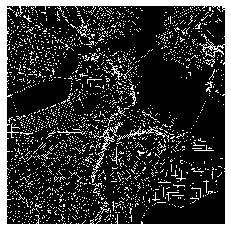

road1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


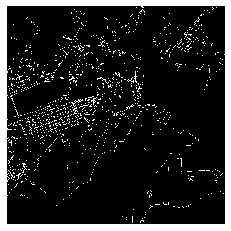

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


build0


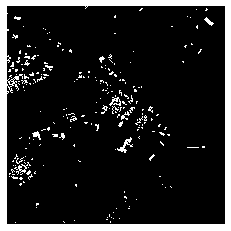

build1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


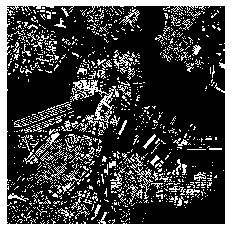

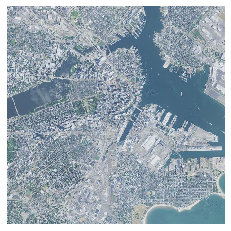

(900, 900)
(900, 900)
(900, 900)
(900, 900)
(900, 900, 3)
[[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [5672.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0. 5672. 5672.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0. 2140. 5672. 6640.    0.    0.    0.    0.]]
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 761.   0.   0.   0.   0.   0.   0.   0.   0.]
 [761. 761.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.

In [6]:
# visualize images to get intuition.
def imshow(image, *args, **kwargs):
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion since 
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
      # Height, width - must be grayscale
      # convert to RGB, since matplotlib will plot in a weird colormap (instead of black = 0, white = 1)
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # Draw the image
    plt.imshow(image, *args, **kwargs)
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis('off')
    # Make sure it outputs
    plt.show()

# Resources about Census Tract IDs
# https://transition.fcc.gov/form477/Geo/more_about_census_tracts.pdf
# Need to use QGIS to obtain the relationship between addresses and census tract IDs.

# Play with examples: Boston, NYC, etc.
print('25025070101' in osm_directory_list)
    
# visualize the images of a census_id    
census_idx = '25025070101' # Boston
# census_idx = '36061016500' # NYC is in the data set.

road_0_ex = osm_dir+'/'+census_idx+'/road_0.tif'
road_1_ex = osm_dir+'/'+census_idx+'/road_1.tif'
building_0_ex = osm_dir+'/'+census_idx+'/building_0.tif'
building_1_ex = osm_dir+'/'+census_idx+'/building_1.tif'
wms_ex = satellite_dir+'/'+'wms'+census_idx+'.jpg'

road_0_img = cv2.imread(road_0_ex, cv2.IMREAD_UNCHANGED)
print("road0")
imshow(road_0_img)
road_1_img = cv2.imread(road_1_ex, cv2.IMREAD_UNCHANGED)
print("road1")
imshow(road_1_img)
building_0_img = cv2.imread(building_0_ex, cv2.IMREAD_UNCHANGED)
print("build0")
imshow(building_0_img)
building_1_img = cv2.imread(building_1_ex, cv2.IMREAD_UNCHANGED)
print("build1")
imshow(building_1_img)
wms_img = cv2.imread(wms_ex, cv2.IMREAD_UNCHANGED)
imshow(wms_img)

# shape
print(road_0_img.shape)
print(road_1_img.shape)
print(building_0_img.shape)
print(building_1_img.shape)
print(wms_img.shape)

# values
print(road_0_img[:10,:10]) # float: larger than 255
print(building_0_img[:10,:10]) # float: larger than 255
print(wms_img[:10,:10,:]) # int: 0-255

[[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [5672.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0. 5672. 5672.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0. 2140. 5672. 6640.    0.    0.    0.    0.]]
(900, 900)
road0


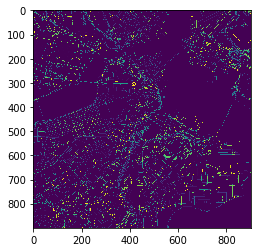

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]]

 [[   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]]

 [[   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]]

 [[   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]]

 [[   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  

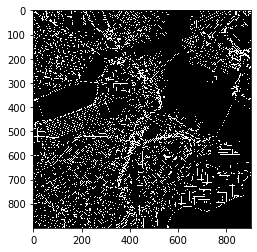

[[[208 194 195]
  [189 175 176]
  [198 186 184]
  [192 181 177]
  [217 206 202]
  [185 175 168]
  [184 177 168]
  [140 133 124]
  [175 168 159]
  [205 198 189]]

 [[176 161 159]
  [158 143 140]
  [159 147 143]
  [188 176 170]
  [182 171 163]
  [177 167 157]
  [204 195 185]
  [123 114 104]
  [134 125 115]
  [186 177 167]]

 [[166 148 141]
  [197 179 172]
  [178 162 155]
  [196 181 172]
  [174 160 148]
  [183 170 156]
  [208 195 181]
  [115 102  86]
  [137 124 108]
  [195 182 166]]

 [[158 138 127]
  [232 215 202]
  [208 191 178]
  [172 156 140]
  [176 160 143]
  [175 159 142]
  [170 155 136]
  [119 104  85]
  [109  94  75]
  [145 130 111]]

 [[165 145 128]
  [178 160 143]
  [181 163 146]
  [135 118  99]
  [166 149 128]
  [156 139 118]
  [149 133 110]
  [141 126 100]
  [109  94  68]
  [114  98  75]]

 [[183 165 148]
  [ 93  76  57]
  [121 104  85]
  [117 100  79]
  [138 121 100]
  [131 113  90]
  [147 130 104]
  [143 126  99]
  [142 125  99]
  [143 126 100]]

 [[189 174 158]
  [100  86  

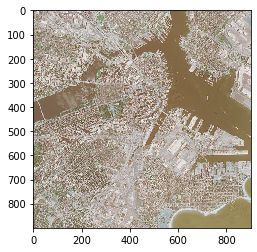

[[[195 194 208]
  [176 175 189]
  [184 186 198]
  [177 181 192]
  [202 206 217]
  [168 175 185]
  [168 177 184]
  [124 133 140]
  [159 168 175]
  [189 198 205]]

 [[159 161 176]
  [140 143 158]
  [143 147 159]
  [170 176 188]
  [163 171 182]
  [157 167 177]
  [185 195 204]
  [104 114 123]
  [115 125 134]
  [167 177 186]]

 [[141 148 166]
  [172 179 197]
  [155 162 178]
  [172 181 196]
  [148 160 174]
  [156 170 183]
  [181 195 208]
  [ 86 102 115]
  [108 124 137]
  [166 182 195]]

 [[127 138 158]
  [202 215 232]
  [178 191 208]
  [140 156 172]
  [143 160 176]
  [142 159 175]
  [136 155 170]
  [ 85 104 119]
  [ 75  94 109]
  [111 130 145]]

 [[128 145 165]
  [143 160 178]
  [146 163 181]
  [ 99 118 135]
  [128 149 166]
  [118 139 156]
  [110 133 149]
  [100 126 141]
  [ 68  94 109]
  [ 75  98 114]]

 [[148 165 183]
  [ 57  76  93]
  [ 85 104 121]
  [ 79 100 117]
  [100 121 138]
  [ 90 113 131]
  [104 130 147]
  [ 99 126 143]
  [ 99 125 142]
  [100 126 143]]

 [[158 174 189]
  [ 68  86 1

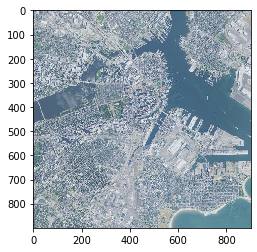

In [7]:
# test the visualization tools in CV2 and plt.
census_idx = '25025070101' # Boston
# census_idx = '36061016500' # NYC is in the data set.

road_0_ex = osm_dir+'/'+census_idx+'/road_0.tif'
road_1_ex = osm_dir+'/'+census_idx+'/road_1.tif'
building_0_ex = osm_dir+'/'+census_idx+'/building_0.tif'
building_1_ex = osm_dir+'/'+census_idx+'/building_1.tif'
wms_ex = satellite_dir+'/'+'wms'+census_idx+'.jpg'

road_0_img = cv2.imread(road_0_ex, cv2.IMREAD_UNCHANGED)
wms_img = cv2.imread(wms_ex, cv2.IMREAD_UNCHANGED)

# test osm images
print(road_0_img[:10, :10])
print(road_0_img.shape)
print("road0")
plt.imshow(road_0_img)
plt.show()

image = cv2.cvtColor(road_0_img, cv2.COLOR_GRAY2RGB)
print(image[:10,:10])
print(image.shape)
print("image")
plt.imshow(image)
plt.show()

# test sat images
print(wms_img[:10, :10, :])
print(wms_img.shape)
print("wmsimg")
plt.imshow(wms_img)
plt.show()

image = cv2.cvtColor(wms_img, cv2.COLOR_BGR2RGB)
print(image[:10,:10])
print(image.shape)
plt.imshow(image)
plt.show()

In [8]:
census_idx = '25025070101' # Boston
print(statesToData["MA"].loc[statesToData["MA"]["CENSUS_ID"] == census_idx, ["HHVEHCNT","TRPTRANS","TRIPPURP"]])
# print(statesToData["MA"]["CENSUS_ID"][statesToData["MA"]["CENSUS_ID"] == census_idx, :])

        HHVEHCNT  TRPTRANS TRIPPURP
200824         0         1        3
200825         0         6        4
200826         0         6        4
200827         0         6        4


In [9]:
print("------")
d_10, d_11 = digit_counts(osm_directory_list)
print("10 digits: ", d_10, "; 11 digits: ", d_11, "Total 10 and 11 digts: ", d_10+d_11)
print("Total items in OSM: ", len(osm_directory_list))

print("------")
d_10, d_11 = digit_counts(sat_directory_list, SAT = True)
print("10 digits: ", d_10, "; 11 digits: ", d_11, "Total 10 and 11 digts: ", d_10+d_11)
print("Total items in SAT: ", len(sat_directory_list))

# Q: There is one unit difference...What is it?

------
10 digits:  7989 ; 11 digits:  27234 Total 10 and 11 digts:  35223
Total items in OSM:  35223
------
10 digits:  7989 ; 11 digits:  27234 Total 10 and 11 digts:  35223
Total items in SAT:  35224


In [10]:
# Count the census IDs in the NHTS data set.
folder_new_id_set = set()
for key in statesToData:
    for census_id in statesToData[key].CENSUS_ID:
        folder_new_id_set.add(census_id)
print("Total census IDs in NHTS: ", len(folder_new_id_set))

Total census IDs in NHTS:  32681


In [11]:
# The image folder names mismatch the official census IDs. 
# Hence we create a list for the image folder's names. 
folder_old_id_list = []
folder_new_id_list = []
sat_file_old_id_list = []
sat_file_new_id_list = []

for id_ in folder_new_id_set:
    if id_[0] == '0':
        folder_old_id_list.append(id_[1:])
        folder_new_id_list.append(id_)
        sat_file_old_id_list.append('wms'+id_[1:]+'.jpg')
        sat_file_new_id_list.append('wms'+id_+'.jpg')        
    else:
        folder_old_id_list.append(id_) # match up to the folder names...
        folder_new_id_list.append(id_)
        sat_file_old_id_list.append('wms'+id_+'.jpg')
        sat_file_new_id_list.append('wms'+id_+'.jpg')        
        
# print check
d_10,d_11 = digit_counts(folder_old_id_list)
print("Old osm folder id list: ", "10 digits: ", d_10, "; 11 digits: ", d_11)
d_10,d_11 = digit_counts(folder_new_id_list)
print("New osm folder id list: ", "10 digits: ", d_10, "; 11 digits: ", d_11)
d_10,d_11 = digit_counts(sat_file_old_id_list, SAT = True)
print("Old sat image files id list: ", "10 digits: ", d_10, "; 11 digits: ", d_11)
d_10,d_11 = digit_counts(sat_file_new_id_list, SAT = True)
print("New sat image files id list: ", "10 digits: ", d_10, "; 11 digits: ", d_11)


Old osm folder id list:  10 digits:  7487 ; 11 digits:  25194
New osm folder id list:  10 digits:  0 ; 11 digits:  32681
Old sat image files id list:  10 digits:  7487 ; 11 digits:  25194
New sat image files id list:  10 digits:  0 ; 11 digits:  32681


In [12]:
# initialize the image array
file_size = (224, 224) # Use a smaller size of images with 224*224
image_array = np.zeros((len(folder_old_id_list), num_channels, file_size[0], file_size[1])) # default: black images
print("Image size is: ", sys.getsizeof(image_array)/1000000000, "GB") 
# Note here the size cannot exceed 16*8 = 128G in RAM. The maximum size here is (249 * 249)

Image size is:  52.473659536 GB


In [13]:
# check the system
psutil.cpu_percent()
psutil.virtual_memory()

svmem(total=134747709440, available=125996208128, percent=6.5, used=7466487808, free=1108463616, active=11519016960, inactive=117501644800, buffers=1705234432, cached=124467523584, shared=704512, slab=4076273664)

In [14]:
census_id_to_index = {}
empty_images_folder_names = []

In [15]:
# Reading images; need 20 min
import os
empty = 0
colored = 0
not_empty = 0

for folder_name_idx in np.arange(len(folder_old_id_list)):
    # create the index dictionary for the folders.
    census_id_to_index[str(folder_new_id_list[folder_name_idx])] = folder_name_idx
    
    if folder_name_idx%100==0:
        print(folder_name_idx)

    # Fill in the OSM images
    for file_name_idx in np.arange(len(standard_file_name_list)):
        full_file_name = os.path.join("/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img/", folder_old_id_list[folder_name_idx], standard_file_name_list[file_name_idx])
        img = cv2.imread(full_file_name, cv2.IMREAD_UNCHANGED)
        if img is None:
            #print("empty")
            #print(standard_file_name_list[file_name_idx])
            empty += 1
            empty_images_folder_names.append(full_file_name)
            pass # default is black images...so when images do not exist. Keep the zeros
        else:
            #print("not empty")
            not_empty += 1
            image_array[folder_name_idx, file_name_idx, :, :] = cv2.resize(img, file_size).astype(np.uint8)

    # Fill in the Satellite images
    sat_file_name = os.path.join("/mnt/shenhao/sat_image_nhts/code/data_initial/satellite/img/", sat_file_old_id_list[folder_name_idx])
    img = cv2.imread(sat_file_name, cv2.IMREAD_UNCHANGED)
    if img is None:
        #print("empty")
        #print(standard_file_name_list[file_name_idx])
        empty += 1
        empty_images_folder_names.append(sat_file_name)
        pass # default is black images...so when images do not exist. Keep the zeros
    else:
        #print("colored")
        colored += 1
        
        
        #commented out because we only want black and white images in this notebook
        
        # idx: 4
#         image_array[folder_name_idx, 4, :, :] = cv2.resize(img[:,:,0], file_size).astype(np.uint8)
#         # idx: 5
#         image_array[folder_name_idx, 5, :, :] = cv2.resize(img[:,:,1], file_size).astype(np.uint8)
#         # idx: 6
#         image_array[folder_name_idx, 6, :, :] = cv2.resize(img[:,:,2], file_size).astype(np.uint8)
        


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [16]:
print("empty: ",empty)
print("colored: ",colored) # note satellite images have no missingness.
print("not empty: ", not_empty)
print(len(empty_images_folder_names))

empty:  14517
colored:  32681
not empty:  116207
14517


['/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img/19125030100/building_0.tif', '/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img/37179020901/road_1.tif', '/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img/55015020200/road_1.tif', '/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img/55015020200/building_0.tif', '/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img/6073020811/building_0.tif', '/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img/48015760502/road_1.tif', '/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img/48015760502/building_0.tif', '/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img/48015760502/building_1.tif', '/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img/48439114104/building_0.tif', '/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img/55031030100/building_0.tif']


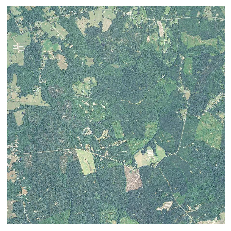

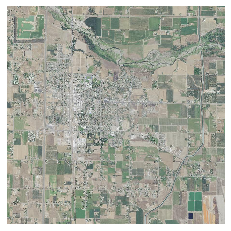

In [17]:
# check emptyness
print(empty_images_folder_names[:10])

empty_index_ex1 = "45057010100" # 11 digits; it misses road_1, building_0, building_1.
empty_index_ex2 = "6021010100" # 10 digits; it misses road_1. Full ID: 06021010100

# example 1
# FIPS 45057: Lancaster County, SC 
wms_ex1 = satellite_dir+'/'+'wms'+empty_index_ex1+'.jpg'
wms_img = cv2.imread(wms_ex1, cv2.IMREAD_UNCHANGED)
imshow(wms_img)

# example 2
# FIPS 06021: Glenn County, CA
wms_ex1 = satellite_dir+'/'+'wms'+empty_index_ex2+'.jpg'
wms_img = cv2.imread(wms_ex1, cv2.IMREAD_UNCHANGED)
imshow(wms_img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


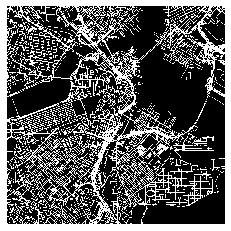

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


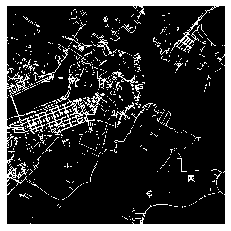

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


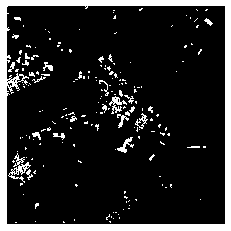

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


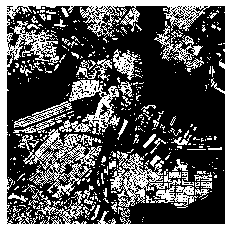

error: OpenCV(4.2.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = (cv::impl::<unnamed>::SizePolicy)2u; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 512


In [18]:
# Double check the processed data. 
census_idx = '25025070101' # Boston
image_idx = census_id_to_index[census_idx]

# note opencv only works with float32 type, and the image_array format (float64) does not work.
road_0_img = image_array[image_idx, 0, :, :].astype('float32') 
imshow(road_0_img)
road_1_img = image_array[image_idx, 1, :, :].astype('float32') 
imshow(road_1_img)
building_0_img = image_array[image_idx, 2, :, :].astype('float32') 
imshow(building_0_img)
building_1_img = image_array[image_idx, 3, :, :].astype('float32') 
imshow(building_1_img)

# note opencv only works with uint8 type with RGB channels, and the image_array format (float64) does not work.
wms_img_ = image_array[image_idx, 4:7, :, :].astype('uint8')
# fotmat editting: from channel-first ot channel-last image
wms_img = np.moveaxis(wms_img_, 0, 2)
imshow(wms_img)

In [19]:
# check census_id_to_index
census_id_keys = list(census_id_to_index.keys())
d_10,d_11 = digit_counts(census_id_keys)
print("Final id list: ", "10 digits: ", d_10, "; 11 digits: ", d_11)

Final id list:  10 digits:  0 ; 11 digits:  32681


In [20]:
len(empty_images_folder_names)

14517

In [21]:
for i,elt in enumerate(empty_images_folder_names):
    print(elt)
    if i == 100:
        break

/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img/19125030100/building_0.tif
/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img/37179020901/road_1.tif
/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img/55015020200/road_1.tif
/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img/55015020200/building_0.tif
/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img/6073020811/building_0.tif
/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img/48015760502/road_1.tif
/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img/48015760502/building_0.tif
/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img/48015760502/building_1.tif
/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img/48439114104/building_0.tif
/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img/55031030100/building_0.tif
/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img/6073017110/building_0.tif
/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img/48315950100/road_1.tif
/mnt/shenhao/sat_image_nhts/code/data_initial/

In [ ]:
keys = list(census_id_to_index.keys())
d_10,d_11 = digit_counts(keys)
print("10 digits: ", d_10, "; 11 digits: ", d_11)

In [ ]:
# save census_id_to_index
import pickle
with open('data_process/census_id_to_index.pickle', 'wb') as handle:
    pickle.dump(census_id_to_index, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
image_array.shape

(32681, 4, 224, 224)

In [23]:
# save image_array ~1 min
np.save("Training/image_array_bw",image_array)

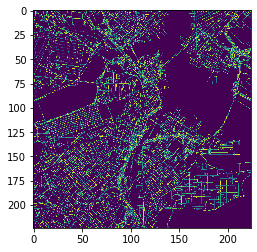

In [24]:
from matplotlib import pyplot as plt
plt.imshow(image_array[image_idx][0], interpolation='nearest')
plt.show()